## Setup

In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans


In [5]:
df_raw = pd.read_csv('./KaDo.csv')

In [6]:
df = df_raw.copy().filter(["PRIX_NET", "NB_T", "MAILLE", "CLI_ID", "LIBELLE"])

In [7]:
df_raw.columns

Index(['TICKET_ID', 'MOIS_VENTE', 'PRIX_NET', 'FAMILLE', 'UNIVERS', 'MAILLE',
       'LIBELLE', 'CLI_ID'],
      dtype='object')

## Recommandation par profile d'acheteur (Gros acheteur ponctuel VS petit acheteur de tous les jours) 

### 1ere Etape: calculer nbr item par panier et total panier pour chaque client


In [8]:
df["NB_T"] = 1

In [9]:
cart_df = df.groupby(["CLI_ID"], as_index=True).sum()

In [10]:
cart_df.head()

,PRIX_NET,NB_T
CLI_ID,,
1490281,18.40,5
13290776,55.50,9
20163348,7.45,1
20200041,6.70,2
20561854,7.05,3


### 2me Etape: calculer nbr item par panier  par client et total panier par client - pour chaque mail


In [11]:
df_maille = df.copy().filter(["PRIX_NET", "NB_T", "MAILLE", "CLI_ID"])
df_maille.head()

,PRIX_NET,NB_T,MAILLE,CLI_ID
0,1.67,1,HYG_JDM,1490281
1,1.66,1,HYG_JDM,1490281
2,7.45,1,VIS_JEUNE_ET_LEVRE,1490281
3,5.95,1,VIS_AAAR_DEMAQLOTION,1490281
4,1.67,1,HYG_JDM,1490281


In [12]:
nb_client_maille = df_maille.groupby(["MAILLE"], as_index=True).sum().filter(["PRIX_NET", "NB_T"])

mail_df = df.groupby(["MAILLE"], as_index=True).sum()
mail_df.head()

,PRIX_NET,CLI_ID,NB_T
MAILLE,,,
CAPILLAIRE_AUTRE,528209.50,102234425421230,104129
CAPILLAIRE_SHAMPOING,728789.98,193161999044150,197236
CORPS_HYDRA_NOURRI_ET_SOINS,2425255.83,502009961459841,513178
CORPS_HYDR_LAIT_HUILE,895789.28,189829965663141,193406
CORPS_MONOI,484101.73,72170784273078,73579


In [13]:
rmder =  df_maille.groupby(["MAILLE", "CLI_ID"], as_index=True).sum().reset_index()["MAILLE"].value_counts()
rmder.head()

VIS_JEUNE_ET_LEVRE             291937
CORPS_HYDRA_NOURRI_ET_SOINS    241988
HYG_JDM                        236116
HYG_PLAISIRNAT_BAIN_SAVON      207534
PARF_PARFUM                    198095
Name: MAILLE, dtype: int64

In [14]:
final_df = mail_df.join(rmder).rename(columns={"MAILLE": "NB_CLI"}).drop(["CLI_ID"], axis=1).reset_index()

final_df["PRIX_NET"] = final_df["PRIX_NET"] / final_df["NB_CLI"]
final_df["NB_T"] = final_df["NB_T"] / final_df["NB_CLI"]

final_df = final_df.drop(["NB_CLI"], axis=1)
final_df.head()

,MAILLE,PRIX_NET,NB_T
0,CAPILLAIRE_AUTRE,8.990188,1.772288
1,CAPILLAIRE_SHAMPOING,7.418842,2.007798
2,CORPS_HYDRA_NOURRI_ET_SOINS,10.022215,2.120675
3,CORPS_HYDR_LAIT_HUILE,6.983514,1.507780
4,CORPS_MONOI,8.817882,1.340237


### 3eme Etape: calcul cluster client


In [15]:
cart_cluster = cart_df.reset_index()
df_cluster = cart_cluster.filter(['PRIX_NET', 'NB_T'])
X = df_cluster
nb_cluster = 99
kmeans = KMeans(n_clusters=nb_cluster, random_state=0).fit(X.values)
df_cluster["label"] = kmeans.labels_
cart_cluster["label"] = kmeans.labels_


In [16]:
cart_cluster.head()

,CLI_ID,PRIX_NET,NB_T,label
0,1490281,18.40,5,79
1,13290776,55.50,9,32
2,20163348,7.45,1,11
3,20200041,6.70,2,11
4,20561854,7.05,3,11


In [17]:
cart_cluster.head()

,CLI_ID,PRIX_NET,NB_T,label
0,1490281,18.40,5,79
1,13290776,55.50,9,32
2,20163348,7.45,1,11
3,20200041,6.70,2,11
4,20561854,7.05,3,11


#### Cluster graph

<AxesSubplot:xlabel='PRIX_NET', ylabel='NB_T'>

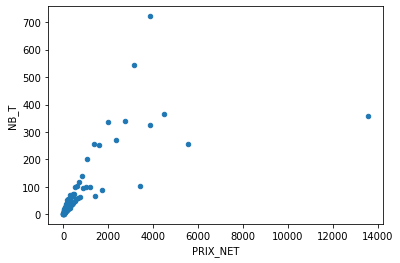

In [18]:
df_cluster_point = pd.DataFrame(kmeans.cluster_centers_, columns=["PRIX_NET", "NB_T"])
df_cluster_point.plot.scatter(x="PRIX_NET", y="NB_T")

In [19]:
df_cluster_point.head()

,PRIX_NET,NB_T
0,18.259294,2.483104
1,153.747281,15.447041
2,414.793836,39.184932
3,62.757657,14.534137
4,3860.350000,325.000000


#### All cient profile clustered graph

In [20]:
plt.style.use('dark_background')

(0.0, 150.0)

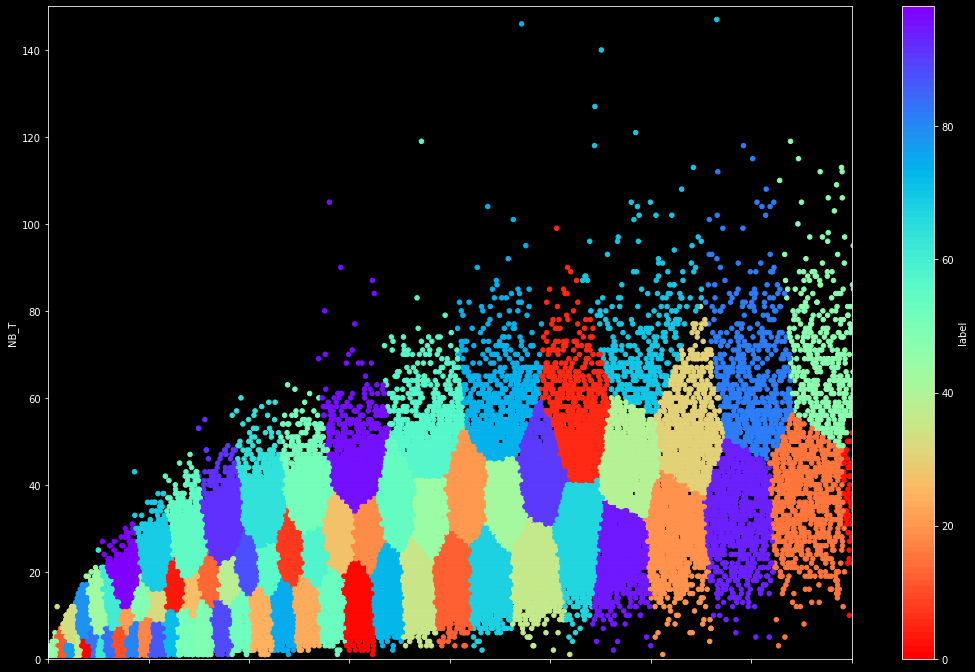

In [21]:
color_map = plt.get_cmap('rainbow', nb_cluster)
reversed_color_map = color_map.reversed()

ax = df_cluster.plot.scatter(x="PRIX_NET", y="NB_T", c="label", colormap=reversed_color_map, figsize=(18,12))

ax.set_xlim([0, 400])
ax.set_ylim([0, 150])

# for i, txt in enumerate(df_cluster_point.index):
#     ax.annotate(txt, (df_cluster_point["PRIX_NET"].iat[i], df_cluster_point["NB_T"].iat[i]), color='black', fontsize=10)

In [22]:
clientId = 1490281

### FULL USER BASED

In [23]:
cart_cluster.reset_index().set_index("CLI_ID")
client_profile = cart_cluster.loc[cart_cluster.CLI_ID == clientId, ['NB_T', "PRIX_NET", "CLI_ID"]].set_index("CLI_ID")

In [24]:
client_profile["label"] = kmeans.predict(client_profile.filter(["PRIX_NET", 'NB_T']).values)[0]

In [25]:
client_profile

,NB_T,PRIX_NET,label
CLI_ID,,,
1490281,5,18.4,79


In [26]:
clientsSelected = cart_cluster[(cart_cluster["label"] == client_profile.iloc[0, 2]) & (cart_cluster["CLI_ID"] != clientId)]
clientSelected = clientsSelected[clientsSelected["CLI_ID"] == np.random.choice(clientsSelected["CLI_ID"].ravel())]
clientIdSelected = clientSelected.iloc[0, 0]


In [27]:
clientSelected

,CLI_ID,PRIX_NET,NB_T,label
771854,994557722,20.45,8,79


### Suggerer un item à partir d'un cluster

In [28]:
print(clientId, clientIdSelected)

1490281 994557722


In [29]:
client_libelle_bought = df[df["CLI_ID"] == clientIdSelected]["LIBELLE"].ravel()

client_libelle_bought

array(['DISSOLVANT FLACON MANUC CN3 100ML', 'LAIT VANILLE PN2 FL50ML',
       'BAUME LEVRES NOIX DE COCO 4G', 'BAUME LEVRES VANILLE 4G',
       'EDT VANILLE PN2 20ML', 'EDT NOIX DE COCO PN2 20ML',
       'GD JDM4 LOTUS FL200ML', 'BD FRAISE PN2 FL50ML'], dtype=object)

In [30]:
np.random.choice(client_libelle_bought)

'BD FRAISE PN2 FL50ML'

### 4eme Etape: trouver le cluster depuis un id client


In [31]:


# cart_df.reset_index()[cart_df.reset_index()["CLI_ID"] > clientId].filter(['PRIX_NET', 'NB_T'])
client_profile = cart_df[cart_df.index == clientId].reset_index().filter(['PRIX_NET', 'NB_T'])

In [32]:
client_profile.values

array([[18.4,  5. ]])

In [33]:
client_label = kmeans.predict(client_profile.values)[0]

### 5eme Etape: trouver quel mail fait parti de se cluster


In [34]:
maille_cluster = final_df.filter(['MAILLE', 'PRIX_NET', 'NB_T'])
# kmeans = KMeans(n_clusters=nb_cluster, random_state=0).fit(X)
# df_cluster["label"] = kmeans.labels_
maille_cluster["label"] = "nan"
test = None
for maille in maille_cluster.values:
    test = kmeans.predict([[maille[1], maille[2]]])
    maille_cluster.at[maille_cluster[maille_cluster['MAILLE'] == maille[0]].index[0], "label"] = test[0]
maille_cluster.head()
maille_cluster["label"].value_counts()

77    11
11     9
37     7
45     2
0      2
62     1
84     1
81     1
Name: label, dtype: int64

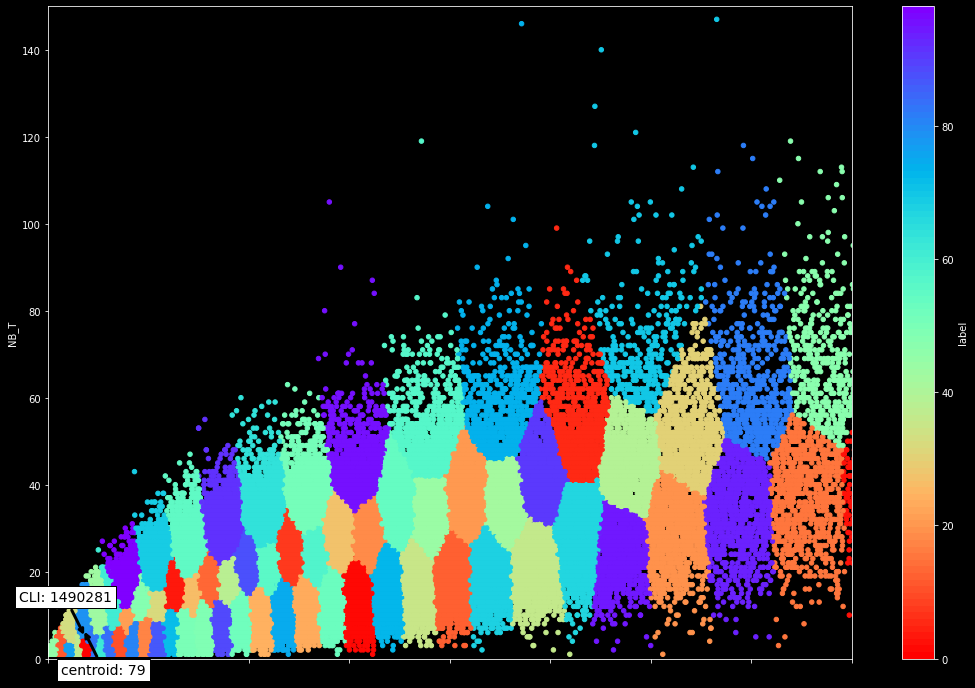

In [35]:
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
color_map = plt.get_cmap('rainbow', nb_cluster)
reversed_color_map = color_map.reversed()


centroid = kmeans.cluster_centers_[client_label]
ax = cart_cluster.plot.scatter(x="PRIX_NET", y="NB_T", c="label", colormap=reversed_color_map, figsize=(18,12))

ax.set_xlim([0, 400])
ax.set_ylim([0, 150])



xy = client_profile.values.ravel()
offsetbox = TextArea("CLI: " + str(clientId), textprops=dict(color="black", fontsize=14))

ab = AnnotationBbox(offsetbox, xy,
                    xybox=(-20, 40),
                    xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->", lw=3, color = "black"))
ax.add_artist(ab)



xy = centroid.ravel()
offsetbox = TextArea("centroid: " + str(client_label), textprops=dict(color="black", fontsize=14))

ab = AnnotationBbox(offsetbox, xy,
                    xybox=(20, -40),
                    xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->", lw=3, color = "black"))
ax.add_artist(ab)

# for i, txt in enumerate(clientSelected["label"]):
#     ax.annotate(".", (maille_cluster["PRIX_NET"].iat[i], maille_cluster["NB_T"].iat[i]), color='black', fontsize=30)

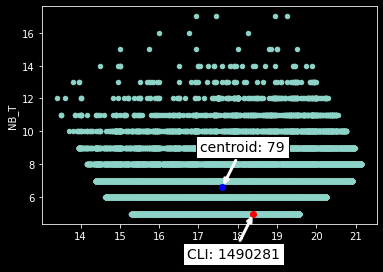

In [36]:
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
color_map = plt.get_cmap('rainbow', nb_cluster)
reversed_color_map = color_map.reversed()
graph_df = cart_cluster[cart_cluster["label"] == client_label]

centroid = kmeans.cluster_centers_[client_label]
ax = graph_df.plot.scatter(x="PRIX_NET", y="NB_T")


xy = client_profile.values.ravel()
offsetbox = TextArea("CLI: " + str(clientId), textprops=dict(color="black", fontsize=14))

ab = AnnotationBbox(offsetbox, xy,
                    xybox=(-20, -40),
                    xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->", lw=3, color = "white"))
ax.add_artist(ab)



xy = centroid.ravel()
offsetbox = TextArea("centroid: " + str(client_label), textprops=dict(color="black", fontsize=14))

ab = AnnotationBbox(offsetbox, xy,
                    xybox=(20, 40),
                    xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->", lw=3, color = "white"))
ax.add_artist(ab)
plt.plot(client_profile.values.ravel()[0],client_profile.values.ravel()[1], marker="o", color="red")
plt.plot(centroid.ravel()[0],centroid.ravel()[1], marker="o", color="blue")


In [37]:
selected_cluster_client = cart_cluster
selected_cluster_client

,CLI_ID,PRIX_NET,NB_T,label
0,1490281,18.40,5,79
1,13290776,55.50,9,32
2,20163348,7.45,1,11
3,20200041,6.70,2,11
4,20561854,7.05,3,11
...,...,...,...,...
853509,997048745,19.80,4,83
853510,997048751,28.80,5,84
853511,997048769,72.65,10,26
853512,997048777,73.70,19,26


In [38]:
df.head()

,PRIX_NET,MAILLE,CLI_ID,LIBELLE,NB_T
0,1.67,HYG_JDM,1490281,GD JDM4 PAMPLEMOUSSE FL 200ML,1
1,1.66,HYG_JDM,1490281,GD JDM4 PAMPLEMOUSSE FL 200ML,1
2,7.45,VIS_JEUNE_ET_LEVRE,1490281,CR JR PARF BIO.SPE AC.SENT.50ML,1
3,5.95,VIS_AAAR_DEMAQLOTION,1490281,EAU MICELLAIRE 3 THES FL200ML,1
4,1.67,HYG_JDM,1490281,GD JDM4 TIARE FL 200ML,1


### 6eme Recommandation dans la mail

In [39]:
all_item_buy_cluster = df[df['CLI_ID'].isin(selected_cluster_client["CLI_ID"])]

In [44]:
all_item_buy_cluster.head()

,PRIX_NET,MAILLE,CLI_ID,LIBELLE,NB_T
0,1.67,HYG_JDM,1490281,GD JDM4 PAMPLEMOUSSE FL 200ML,1
1,1.66,HYG_JDM,1490281,GD JDM4 PAMPLEMOUSSE FL 200ML,1
2,7.45,VIS_JEUNE_ET_LEVRE,1490281,CR JR PARF BIO.SPE AC.SENT.50ML,1
3,5.95,VIS_AAAR_DEMAQLOTION,1490281,EAU MICELLAIRE 3 THES FL200ML,1
4,1.67,HYG_JDM,1490281,GD JDM4 TIARE FL 200ML,1


In [65]:
np.random.choice(all_item_buy_cluster["LIBELLE"])

'MDT HUILE TIARE TRAD VPM 100ML'

In [85]:
top_5_recommndation = all_item_buy_cluster["LIBELLE"].value_counts().head().index.to_numpy()
top_5_recommndation

In [86]:
top_1_recommndation = top_5_recommndation[0]
top_1_recommndation

'DEMAQ EXPRESS PUR BLEUET FL125ML'